# Default of Credit Cards Clients

We will implement a decision tree based classifiers to attempt prediction of whether or not a customer will default on their loans. 

Given a number of personal variables, (sex, education, marriage status, age); and recent payment history, attempt to predict whether or not a customer will default in the next month.  

[Defaults of credit card clients](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#)  

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

%matplotlib inline

In [31]:
# Read in Data
df = pd.read_excel("default of credit card clients.xls", header = 1)

df.rename(columns = {"PAY_0":"PAY_1"}, inplace = True) 
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


# Explore the Data

---

We have no null data

In [32]:
print("Data Shape: " , df.shape, "\n")
df.info()

Data Shape:  (30000, 25) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_1                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 

## Feature Distribution 

Take a look at the distribution of our target feature for classification '`default payment next month`'

In [33]:
df['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

The code-book only describes the education variable as having four values (1-4), here, there are seven values (0-6).  
In some cases this might be grounds to throw out these unknown values (0,5,6). For now, we will leave them in, assuming that they have some (unknown to us) meaning.

In [34]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

Again, the code book only describes three values for marriage (1-3), yet here, "0" also appears. Given what we saw above, we might assume the "0" in these categorical variables is functionally used for the "null" value

In [35]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

A slight imbalance exists representation of men and women, with women making up a little over 60% of our observations. Thankfully this column contains no "0"s.

In [36]:
df['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

## Closer look to "PAY" variables

In [37]:
df['PAY_1'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64

### Investigate relationship between "Pay", "Bill_amt" and "Pay_amt" variables

In [38]:
for i in [-2,-1,0,1,2,8]:
    print(df[df['PAY_1']==i][['PAY_1','BILL_AMT1','PAY_AMT1']].head(8), "\n")

    PAY_1  BILL_AMT1  PAY_AMT1
9      -2          0         0
23     -2       5512     19428
33     -2      10929      4152
34     -2      13709      5006
45     -2          0         0
52     -2      13465      7875
55     -2       1905      3640
65     -2     152519         0 

    PAY_1  BILL_AMT1  PAY_AMT1
1      -1       2682         0
4      -1       8617      2000
11     -1      12261     21818
12     -1      12137      1000
21     -1        316       316
28     -1        650      3415
30     -1      16646     17270
35     -1      30265       131 

    PAY_1  BILL_AMT1  PAY_AMT1
2       0      29239      1518
3       0      46990      2000
5       0      64400      2500
6       0     367965     55000
7       0      11876       380
8       0      11285      3329
10      0      11073      2306
14      0      70887      3000 

    PAY_1  BILL_AMT1  PAY_AMT1
13      1      65802      3200
15      1      50614         0
18      1          0         0
19      1          0         0
26

It is unclear exactly how these "PAY" variables work. Maybe they should be treated as categorical data instead of discrete and interval data, but, for this modeling task we will keep them as interval data.

In [39]:
# Function for creating histograms
def pay_hist(df, cols, ymax):
    
    # fig size
    plt.figure(figsize= (10,7)) 
    
    # For each column passed to function
    for index, col in enumerate(cols): 
        
        # plot on new subplot
        plt.subplot(2,3, index +1) 
        
        # standardize ymax
        plt.ylim(ymax = ymax) 
        
        # create hist
        plt.hist(df[col]) 
        
        # title with column names
        plt.title(col)
        
    # make sure titles don't overlap
    plt.tight_layout(); 

pay_cols = ["PAY_"+str(n) for n in range(1,7)]
pay_amt_cols = ['PAY_AMT' + str(n) for n in range(1,7)]
bill_amt_cols = ['BILL_AMT' + str(n) for n in range(1,7)]

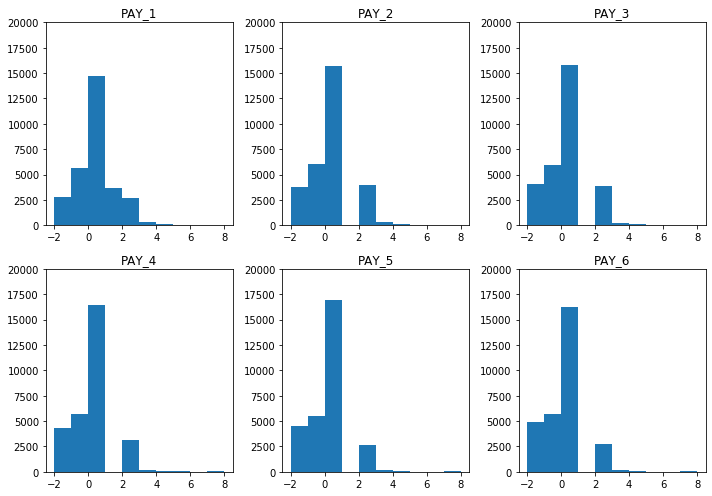

In [40]:
# generate the histograms for pay variables
pay_hist(df, pay_cols, 20000)

From above "0" is the majority class for all of the "PAY" variables. But, it is unclear for us what a "0" means as it is not in the code book.

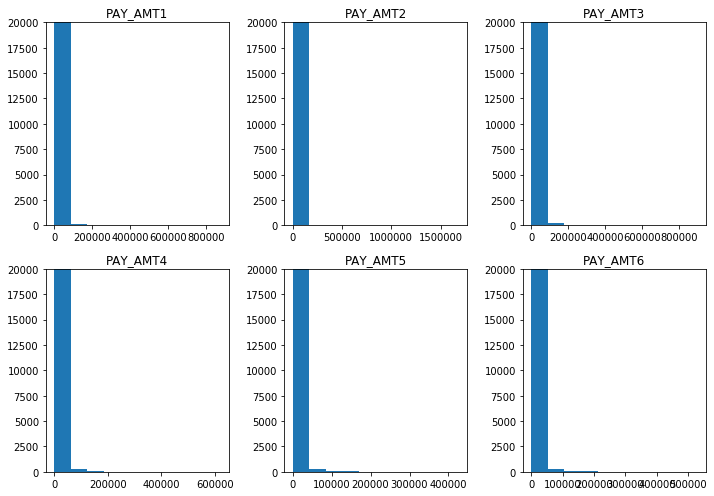

In [41]:
pay_hist(df, pay_amt_cols, 20000)

The 'PAY_AMT' variables are also around "0" 

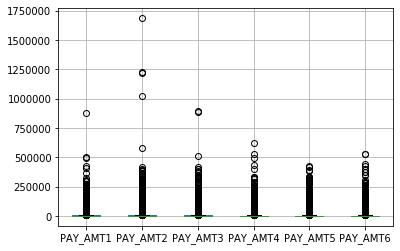

In [42]:
df[pay_amt_cols].boxplot();

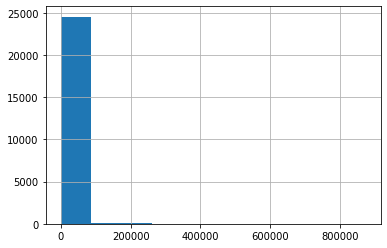

In [43]:
df_no_0_pay_amt_1 = df[df["PAY_AMT1"]!=0]
df_no_0_pay_amt_1["PAY_AMT1"].hist()

Even taking out all the PAY_AMT of 0, most payments stay close to 0 with a long tail.

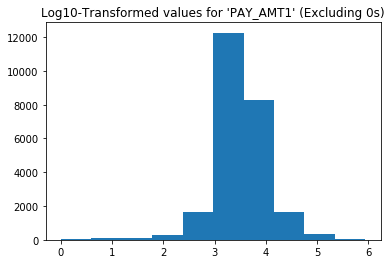

In [44]:
log_pay_amt1 = np.log10(df_no_0_pay_amt_1["PAY_AMT1"])
plt.hist(log_pay_amt1)
plt.title("Log10-Transformed values for 'PAY_AMT1' (Excluding 0s)");

The log Transformation can be a good way of looking more closely at skewed data. Above, we see that most of the repayment amounts are in the 1000's of dollars.

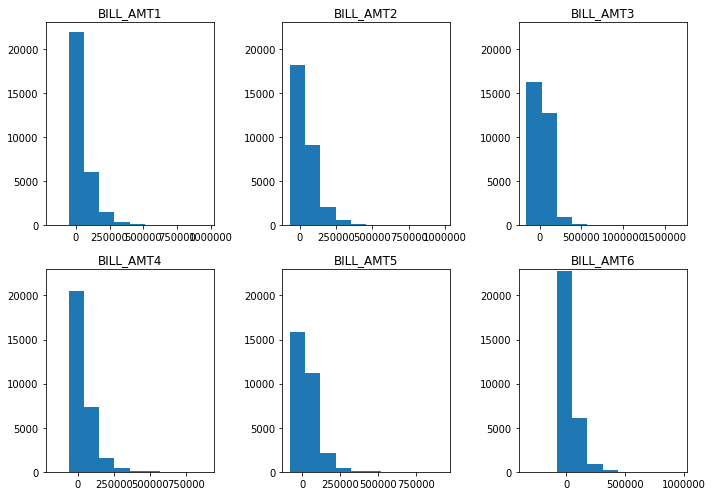

In [45]:
pay_hist(df, bill_amt_cols, 23000)

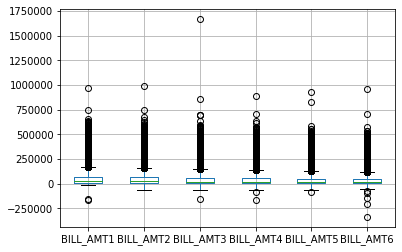

In [46]:
df[bill_amt_cols].boxplot();

# Preprocessing

---

Currently "Sex" is coded as 2 for "female" and 1 for "male". As this is encoded as binary we will change the column name to "FEMALE" and subtract 1 from each value - thus 1 will be "Female" and 0 "Male".

Both Education and Marriage are categorical with multiple options. `pd.get_dummies()` will allow us to create n-1 binary features to encode the n categories.  

In [47]:
# change vals of 'sex' to 0,1
df['SEX'] = df['SEX']-1 

# rename col names
df.rename(columns = {'SEX':'FEMALE', "default payment next month":"default"}, inplace = True) 

# get dummies and rename cols for ed and marraige
for col, pre in zip(["EDUCATION", "MARRIAGE"],["EDU","MAR"]): 
    df = pd.concat([df.drop(col, axis = "columns"), pd.get_dummies(df[col], prefix = pre, drop_first = True)],
    axis = 'columns')
    

df.head()

,ID,LIMIT_BAL,FEMALE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,default,EDU_1,EDU_2,EDU_3,EDU_4,EDU_5,EDU_6,MAR_1,MAR_2,MAR_3
0,1,20000,1,24,2,2,-1,-1,-2,-2,...,1,0,1,0,0,0,0,1,0,0
1,2,120000,1,26,-1,2,0,0,0,2,...,1,0,1,0,0,0,0,0,1,0
2,3,90000,1,34,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,4,50000,1,37,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,5,50000,0,57,-1,0,-1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


# Trees and Forests

Given a target (categorical or continuous), a decision tree iteratively splits data. It splits data at the value in whichever feature that creates the greatest separation among the target variable.

## Depth
 
The maximum depth to which a is allowed to grow can be specified with `max_depth` in `sklearn`. By default, `max_depth` it is set to `None` which means the tree will grow until all leaves (terminal nodes) are pure, or until other user-specified criteria are met. Importantly, `max_depth` can impact the amount of time it takes to build a tree (this becomes especially important when starting to work with forests).  

## Splitting

In the `sklearn` package two splitting criterion are available for classifiers; "gini" and "entropy". In general, "gini" splitting favors larger partitions, where "entropy" favors splitting of smaller groups that are of a single class. 

## Gini and Entropy Calculations

The gini-index for a node is: $$1- \sum_{j=1}^n p^2_j$$  
Where there are n classes and $p_j$ is the frequency of class j in that node.

Finally, the indexes for each of these nodes is weighted by the proportion of data at each node, then summed.  
Remember gini-indicies closer to 0 are more "pure"

[More on Gini/Entropy](http://www.learnbymarketing.com/481/decision-tree-flavors-gini-info-gain/)

## Forests

"Forests" are collections of decision trees designed to protect against over-fitting.  
A single decision tree (particularly one that is allowed to grow to any depth), may be prone to overfitting.

Algorithmically, the tree is designed to continue to make splits until it has completely classified all of the available data, and/or exhausted every possible split. Thus, no complexity and no particular is too fine for the tree to split upon. 

A tree might be "pruned" (by setting max_depth) to protect against over fitting, but a "forest" of trees might also be used instead.  

---

# Building Tree / Forest Models  

Assume we are predicting default/not-default, our baseline accuracy is the percentage of observations that would be correctly predicted if we predicted the majority class every time (the best of the case for prediction performance of the model). 

In [52]:
ba = max(df['default'].value_counts()/df.shape[0])*100 
print("Baseline Accuracy:", ba)

Baseline Accuracy: 77.88000000000001


Create train-test split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("default", axis = 'columns'), df['default'],
    test_size = .3, random_state = 1738)

Instantiation of trees and forest models

In [55]:
dt = DecisionTreeClassifier()
bag = BaggingClassifier()
rf = RandomForestClassifier()
et = ExtraTreesClassifier()

## Performance of classifiers using default parameters

In [56]:
dt.fit(X_train, y_train)
print("Decision Tree: \n", classification_report(y_test, dt.predict(X_test)), "\n")
print("-----------")

bag.fit(X_train, y_train)
print("Bagging: \n", classification_report(y_test, bag.predict(X_test)), "\n")
print("-----------")

rf.fit(X_train, y_train)
print("Random Forest: \n", classification_report(y_test, rf.predict(X_test)), "\n")
print("------------")

et.fit(X_train, y_train)
print("Extra Trees: \n", classification_report(y_test, et.predict(X_test)), "\n")

Decision Tree: 
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      7042
           1       0.37      0.39      0.38      1958

    accuracy                           0.72      9000
   macro avg       0.60      0.60      0.60      9000
weighted avg       0.73      0.72      0.72      9000
 

-----------
Bagging: 
               precision    recall  f1-score   support

           0       0.83      0.94      0.88      7042
           1       0.60      0.32      0.42      1958

    accuracy                           0.81      9000
   macro avg       0.72      0.63      0.65      9000
weighted avg       0.78      0.81      0.78      9000
 

-----------
Random Forest: 
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      7042
           1       0.64      0.34      0.45      1958

    accuracy                           0.81      9000
   macro avg       0.74      0.64      0.67      9000
w

It appears both the Random Forest and the Extra Trees perform in a similarly effective manner. It is benefitial to increase the performance of both models. 

# Hyper Parameter Tuning

First will try to increase the performance of the Random Forest by tuning a couple hyper parameters; `criterion` and `estimators`. 

Because we are more interested in forecasting defaults than non-defaults, we will optimize on the recall of defaults(proportion of defaults predicted over total defaults, can be thought of as the "sensitivity").  

While it might be tempting to try to tune-and-tune-and-tune hyper-parameters to increase scores, in many cases hyper-parameter tuning mostly results in not creating a better model, but a model that does a better job of predicting the test set.  

In [60]:
%%time

criterion = ['gini', 'entropy']
n_estimators = [5,10,20, 50, 100]
scores = dict()
i = 0
for c in criterion:
     for e in n_estimators:
         rf = RandomForestClassifier(n_estimators = e, criterion = c, random_state = 1738)
         rf.fit(X_train, y_train)
         scores[i] = {'recall':recall_score(y_test, rf.predict(X_test)), 'trees' :e, "crit":c}
         i+=1

CPU times: user 25.9 s, sys: 3.42 ms, total: 25.9 s
Wall time: 25.9 s


In [76]:
df_scores = pd.DataFrame(scores).T
df_scores

,recall,trees,crit
0,0.365679,5,gini
1,0.318693,10,gini
2,0.333504,20,gini
3,0.350868,50,gini
4,0.350868,100,gini
5,0.364147,5,entropy
6,0.321757,10,entropy
7,0.331971,20,entropy
8,0.341164,50,entropy
9,0.342697,100,entropy


According to the output shown in the picture above, the model that has the best recall score featured uses the gini splitting method and uses five trees. 

It is useful to see it in a plot. 

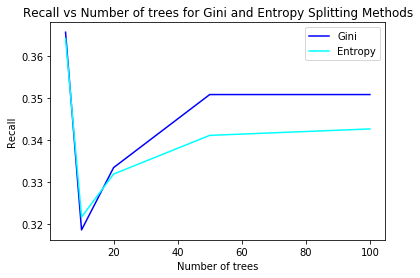

In [91]:
plt.plot(df_scores.loc[df_scores['crit'] == 'gini']['trees'], df_scores.loc[df_scores['crit'] == 'gini']['recall'], label = 'Gini', color = 'blue')
plt.plot(df_scores.loc[df_scores['crit'] == 'entropy']['trees'], df_scores.loc[df_scores['crit'] == 'entropy']['recall'], label = 'Entropy', color = 'cyan')

plt.title('Recall vs Number of trees for Gini and Entropy Splitting Methods')
plt.xlabel('Number of trees')
plt.ylabel('Recall')
plt.legend()

The optimal model until now consists of a `RandomForestClassifier` will performs best using `gini` splittling with somewhere around 5 trees. 

We will try to optimize even more its performance. 

In [92]:
n_estimators = [1,2,3,4,5,6,7,8]
scores2 = dict()
i = 0
for e in n_estimators:
     rf = RandomForestClassifier(n_estimators = e, criterion = 'gini', random_state = 1738)
     rf.fit(X_train, y_train)
     scores2[i] = {'recall':recall_score(y_test, rf.predict(X_test)), 'trees' :e}
     i+=1

In [94]:
df_scores2 = pd.DataFrame(scores2).T
df_scores2

,recall,trees
0,0.416241,1.0
1,0.223698,2.0
2,0.375894,3.0
3,0.267109,4.0
4,0.365679,5.0
5,0.281920,6.0
6,0.367722,7.0
7,0.305414,8.0


The behaviour its clearer in a plot

Text(0, 0.5, 'Recall')

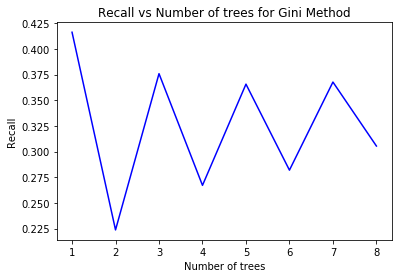

In [97]:
plt.plot(df_scores2['trees'], df_scores2['recall'], label = 'Gini', color = 'blue')

plt.title('Recall vs Number of trees for Gini Method')
plt.xlabel('Number of trees')
plt.ylabel('Recall')

When focusing on 'Gini' random forests with between 1 and 8 trees it becomes clear that increasing the number of trees is ambigous in terms of recall. We can not conclude if more trees are "better" or "worse" in terms of recall on our model.

Finally our hyper-parameter tuning did not created a better model, but rather it created a model that predicted better the data test set. 